In [1]:
#pip install torch transformers numpy matplotlib
#pip install sentencepiece

cuda


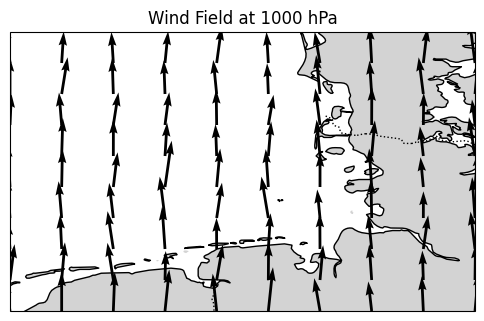

Example Text Description: Strong southerly winds with speeds around 15.0 m/s over the North Sea.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import T5Tokenizer, T5ForConditionalGeneration
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from transformers import EncoderDecoderCache
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import numpy as np

def generate_wind_field(grid_size=10, base_wind_dir=315, wind_speed=None):
    lon_min, lon_max = 5, 10
    lat_min, lat_max = 53, 56
    
    lon = np.linspace(lon_min, lon_max, grid_size)
    lat = np.linspace(lat_min, lat_max, grid_size)
    LON, LAT = np.meshgrid(lon, lat)
        
    # Apply random wind direction variations (±10°) per grid point
    theta_variation = np.random.uniform(-10, 10, size=(grid_size, grid_size))  # Random per grid point
    theta = np.deg2rad(270 - (base_wind_dir + theta_variation))  # Convert to radians
    
    # Compute U and V components with the varied wind directions
    U = wind_speed * np.cos(theta)
    V = wind_speed * np.sin(theta)
    
    return LON, LAT, U, V, wind_speed


# 2. Plot wind field with Cartopy
def plot_wind_field(LON, LAT, U, V, title="Wind Field at 1000 hPa"):
    fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([5, 10, 53, 56], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    
    # Plot wind vectors
    ax.quiver(LON, LAT, U, V, scale=200, transform=ccrs.PlateCarree())
    
    ax.set_title(title)
    plt.savefig(f"coastal_wind.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. Generate synthetic textual descriptions
def generate_text_description(wind_speed, wind_dir):
    if np.mean(wind_speed) > 12:
        intensity = "strong"
    elif np.mean(wind_speed) > 6:
        intensity = "moderate"
    else:
        intensity = "light"
    
    directions = {
        0: "northerly", 45: "northeasterly", 90: "easterly", 135: "southeasterly",
        180: "southerly", 225: "southwesterly", 270: "westerly", 315: "northwesterly"
    }
    
    # Adjust wind_dir to the closest main direction within ±10%
    def get_direction(wind_dir):
        main_directions = np.array(list(directions.keys()))
        closest_dir = main_directions[np.argmin(np.abs(main_directions - wind_dir))]
        return directions.get(closest_dir, "variable")    
    
    direction = get_direction(round(wind_dir))
    approx_speed = [0, 1, 2, 5, 10, 15, 20, 25, 30][np.argmin(np.abs([0, 1, 2, 5, 10, 15, 20, 25, 30] - np.mean(wind_speed)))]

    return f"{intensity.capitalize()} {direction} winds with speeds around {approx_speed:.1f} m/s over the North Sea."

import time
import matplotlib.pyplot as plt

def train_transformer(text_samples, wind_fields, num_epochs=10):
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    
    loss_history = []  # Store loss values for each epoch
    start_time = time.time()  # Start overall training timer

    for epoch in range(num_epochs):
        epoch_start = time.time()  # Start timer for this epoch
        total_loss = 0

        for wind, text in zip(wind_fields, text_samples):
            U, V, wind_speed = wind  # Unpack U, V, and wind_speed
            
            # Format the wind field as structured text instead of raw numbers
            wind_input = (
                f"Wind field: U: {' '.join(map(str, np.round(U.flatten()[:20], 2)))}; "
                f"V: {' '.join(map(str, np.round(V.flatten()[:20], 2)))}; "
                f"Speed: {' '.join(map(str, np.round(wind_speed.flatten()[:20], 2)))}."
            )
            
            input_ids = tokenizer.encode(wind_input, return_tensors="pt", truncation=True, max_length=512).to(device)
            labels = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=512).to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(text_samples)  # Compute average loss per epoch
        loss_history.append(avg_loss)  # Store loss

        # Time calculations
        epoch_time = time.time() - epoch_start  # Time taken for this epoch
        elapsed_time = time.time() - start_time  # Total elapsed time
        estimated_total_time = (elapsed_time / (epoch + 1)) * num_epochs  # Estimate full training time
        remaining_time = estimated_total_time - elapsed_time  # Remaining estimated time

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s | "
              f"Elapsed: {elapsed_time:.2f}s | Remaining: {remaining_time:.2f}s")

    return model, tokenizer, loss_history  # Return loss history for plotting

def generate_forecast(model, tokenizer, wind_field):
    U, V = wind_field  # Unpack U and V components

    # Format the input as structured text for better model understanding
    wind_input = (
        f"Wind field: U: {' '.join(map(str, np.round(U.flatten()[:20], 2)))}; "
        f"V: {' '.join(map(str, np.round(V.flatten()[:20], 2)))}."
    )

    input_ids = tokenizer.encode(wind_input, return_tensors="pt", truncation=True, max_length=512).to(device)

    # Generate text forecast
    output = model.generate(input_ids)
    
    # Decode the generated output properly
    forecast_text = tokenizer.decode(output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return forecast_text

# Create dataset for training
text_samples, wind_fields = [], []

for _ in range(50):
    base_wind_dir = random.choice([0, 90, 180, 270, 315])  # Base wind direction
    base_speed = random.uniform(5, 30)  # Base wind speed (5-30 m/s)

    # Generate wind speed with slight variation around the base speed (±10%)
    wind_speed = np.clip(np.random.normal(base_speed, base_speed * 0.1, (10, 10)), 0, 30)

    # Generate wind field with local variations in direction
    LON, LAT, U, V, wind_speed = generate_wind_field(base_wind_dir=base_wind_dir, wind_speed=wind_speed)

    # Generate text description based on base wind direction
    text_samples.append(generate_text_description(wind_speed, base_wind_dir))
    wind_fields.append((U, V, wind_speed))


# Display Example
plot_wind_field(LON, LAT, U, V)
text_desc = generate_text_description(wind_speed, base_wind_dir)
print("Example Text Description:", text_desc)


In [3]:
# Debug: Print a few samples from the training dataset
print("\n=== SAMPLE TRAINING DATA ===\n")
for i in range(10):  # Print 5 samples
    U, V, wind_speed = wind_fields[i]  # Unpack components
    
    # Format the input
    wind_input = (
        f"Wind field {i+1}:\n"
        f"U: {' '.join(map(str, np.round(U.flatten()[:10], 2)))} ...\n"
        f"V: {' '.join(map(str, np.round(V.flatten()[:10], 2)))} ...\n"
        f"Speed: {' '.join(map(str, np.round(wind_speed.flatten()[:10], 2)))} ..."
    )
    
    print(f"INPUT {i+1}:\n{wind_input}\n")
    print(f"OUTPUT {i+1} (Expected Description):\n{text_samples[i]}\n")
    print("-" * 50)



=== SAMPLE TRAINING DATA ===

INPUT 1:
Wind field 1:
U: -26.38 -29.81 -26.33 -29.66 -26.08 -29.17 -27.19 -22.76 -29.79 -20.16 ...
V: -0.35 -3.36 -1.65 -4.51 -1.84 2.31 1.2 3.54 -3.55 -0.88 ...
Speed: 26.38 30.0 26.38 30.0 26.14 29.27 27.21 23.03 30.0 20.18 ...

OUTPUT 1 (Expected Description):
Strong easterly winds with speeds around 25.0 m/s over the North Sea.

--------------------------------------------------
INPUT 2:
Wind field 2:
U: 0.87 -1.58 -2.83 -1.06 -0.33 -1.53 -3.46 2.74 3.49 0.43 ...
V: -22.28 -18.99 -16.62 -18.16 -21.59 -19.9 -20.21 -18.68 -20.82 -17.21 ...
Speed: 22.3 19.06 16.86 18.19 21.59 19.96 20.5 18.88 21.11 17.21 ...

OUTPUT 2 (Expected Description):
Strong northerly winds with speeds around 20.0 m/s over the North Sea.

--------------------------------------------------
INPUT 3:
Wind field 3:
U: -2.71 -2.03 -2.22 2.44 -1.89 2.32 -1.45 -0.0 0.75 -2.4 ...
V: -17.87 -16.26 -18.57 -16.55 -17.08 -16.93 -18.73 -18.18 -18.06 -18.39 ...
Speed: 18.07 16.39 18.71 16.73 1

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/30 | Loss: 1.2360 | Time: 5.28s | Elapsed: 5.28s | Remaining: 153.24s
Epoch 2/30 | Loss: 0.2030 | Time: 4.90s | Elapsed: 10.19s | Remaining: 142.62s
Epoch 3/30 | Loss: 0.1040 | Time: 5.26s | Elapsed: 15.44s | Remaining: 139.00s
Epoch 4/30 | Loss: 0.0601 | Time: 5.03s | Elapsed: 20.48s | Remaining: 133.09s
Epoch 5/30 | Loss: 0.0441 | Time: 5.34s | Elapsed: 25.81s | Remaining: 129.07s
Epoch 6/30 | Loss: 0.0256 | Time: 5.66s | Elapsed: 31.48s | Remaining: 125.91s
Epoch 7/30 | Loss: 0.0133 | Time: 5.32s | Elapsed: 36.80s | Remaining: 120.91s
Epoch 8/30 | Loss: 0.0160 | Time: 5.25s | Elapsed: 42.05s | Remaining: 115.64s
Epoch 9/30 | Loss: 0.0061 | Time: 5.46s | Elapsed: 47.51s | Remaining: 110.86s
Epoch 10/30 | Loss: 0.0043 | Time: 5.43s | Elapsed: 52.95s | Remaining: 105.89s
Epoch 11/30 | Loss: 0.0075 | Time: 5.48s | Elapsed: 58.43s | Remaining: 100.92s
Epoch 12/30 | Loss: 0.0084 | Time: 5.85s | Elapsed: 64.28s | Remaining: 96.41s
Epoch 13/30 | Loss: 0.0472 | Time: 5.15s | Elapsed:

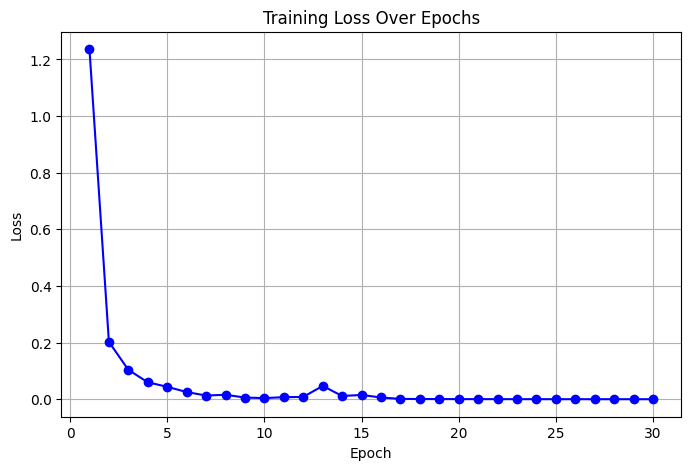

In [4]:
# Train model and store loss history
model, tokenizer, loss_history = train_transformer(text_samples, wind_fields, num_epochs=30)

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()


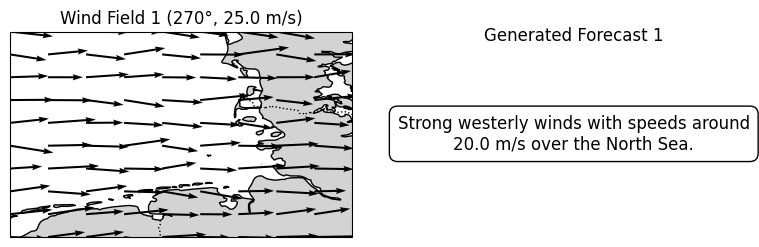

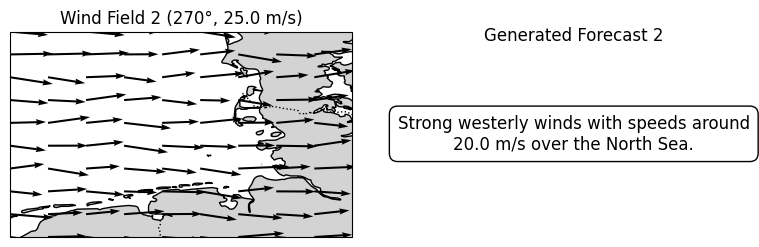

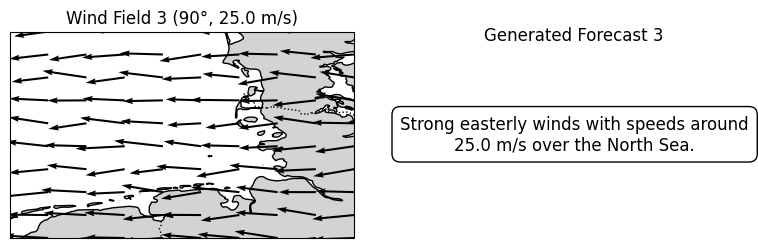

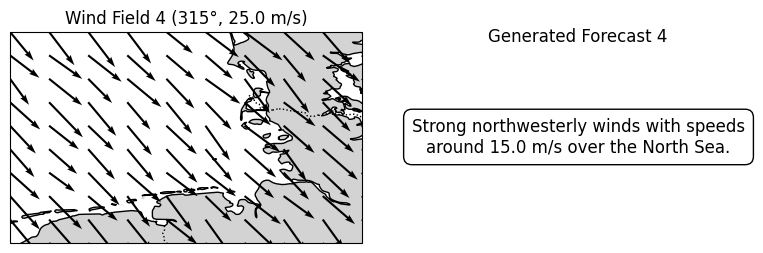

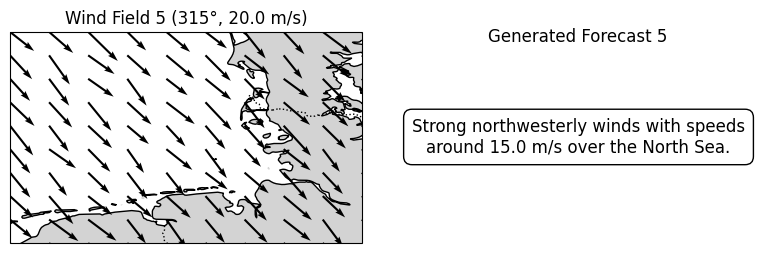

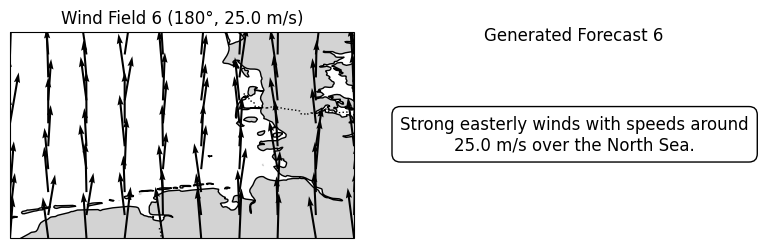

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from torch import nn
from transformers import T5Tokenizer, T5ForConditionalGeneration
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from transformers import EncoderDecoderCache
import textwrap

def test_forecast(model, tokenizer, ntest=10):

    for i in range(ntest):
        fig, axes = plt.subplots(1, 2, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        # Choose a base wind direction with small variations at each grid point
        base_wind_dir = random.choice([0, 90, 180, 270, 315])  
        base_speed = random.uniform(5, 30)  # Base wind speed (5-30 m/s)

        # Generate wind speed with slight variation around the base speed (±10%)
        wind_speed = np.clip(np.random.normal(base_speed, base_speed * 0.1, (10, 10)), 0, 30)
        approx_speed = [0, 1, 2, 5, 10, 15, 20, 25, 30][np.argmin(np.abs([0, 1, 2, 5, 10, 15, 20, 25, 30] - np.mean(wind_speed)))]

        # Generate wind field with local direction variations at each grid point
        LON, LAT, U, V, wind_speed = generate_wind_field(base_wind_dir=base_wind_dir, wind_speed=wind_speed)

        # Generate forecast text
        predicted_text = generate_forecast(model, tokenizer, np.array([U, V]))

        # Plot wind field
        ax = axes[0]
        ax.set_extent([5, 10, 53, 56], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.quiver(LON, LAT, U, V, scale=200, transform=ccrs.PlateCarree())
        ax.set_title(f"Wind Field {i+1} ({base_wind_dir}°, {approx_speed:.1f} m/s)")


        wrapped_text = "\n".join(textwrap.wrap(predicted_text, width=40))  # Limit to 40 characters per line

        axes[1].text(0.5, 0.5, wrapped_text, ha='center', va='center', fontsize=12, wrap=True,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].set_frame_on(False)
        axes[1].set_title(f"Generated Forecast {i+1}")

        plt.tight_layout()
        plt.savefig(f"coastal_fcst_{i:02d}.png", dpi=300, bbox_inches='tight')
    
        plt.show()

# Run the test function
test_forecast(model, tokenizer, ntest=6)